# CNN 
* Pre trained using weights of 'best' model: densenet121_NotNorm.pth
* Use saliency maps for generation of bounding boxes

* test_loader is full test set but small_test_loader is smaller test set (12) for inspecting visual XAI

## Load Data

In [2]:
import os
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torch import nn, optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import time
import collections
from collections import Counter
from sklearn.model_selection import train_test_split

In [3]:

# Data class for DRData
class DRData(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Function to load data paths and labels from a directory
def load_image_paths_and_labels(root_dir, subset):
    image_paths = []
    labels = []

    subdir = f'{subset}/subset_ND'
    dir_path = os.path.join(root_dir, subdir)

    for filename in os.listdir(dir_path):
        if filename.endswith('.png'):
            image_paths.append(os.path.join(dir_path, filename))
            label = 1 if filename.split('_')[1].startswith('D') else 0  # 1 for DR, 0 for NO DR
            labels.append(label)

    return image_paths, labels


# Function to split the dataset in a stratified way
def stratified_split(image_paths, labels, test_size=0.15):
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=test_size, stratify=labels, random_state=18
    )

    return train_paths, train_labels, val_paths, val_labels


# Define transforms (for example, resizing to 224x224 for Vision Transformers)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

root_dir = 'Data'

### TRAIN DATA ###
train_image_paths, train_labels = load_image_paths_and_labels(root_dir, subset='train')

# Perform the stratified split to ensure balanced train/val sets
train_paths, train_labels, val_paths, val_labels = stratified_split(train_image_paths, train_labels)

# Create the train and validation datasets
train_dataset = DRData(image_paths=train_paths, labels=train_labels, transform=data_transforms)
val_dataset = DRData(image_paths=val_paths, labels=val_labels, transform=data_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


### TEST DATA ###
# normal test set
test_image_paths, test_labels = load_image_paths_and_labels(root_dir, subset='test')
test_dataset = DRData(image_paths=test_image_paths, labels=test_labels, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# small test set for inspecting visual xai outcomes: subset from test set called "SmallTestObvious"
small_test_image_paths, small_test_labels = load_image_paths_and_labels(root_dir, subset='testSMALL')
small_test_dataset = DRData(image_paths=small_test_image_paths, labels=small_test_labels, transform=data_transforms)
small_test_loader = DataLoader(small_test_dataset, batch_size=16, shuffle=False)



### Check distribution

In [15]:
# Check the distribution 
def check_data_distribution(labels, dataset_name='Dataset'):
    class_counts = Counter(labels)
    print(f"Data Distribution for {dataset_name}:")
    for label, count in class_counts.items():
        print(f"Class {label}: {count} samples")

check_data_distribution(train_labels, 'Training Dataset (Stratified)')
check_data_distribution(val_labels, 'Validation Dataset (Stratified)')
check_data_distribution(test_labels, 'Test Dataset (Stratified)')
check_data_distribution(small_test_labels, 'Test Dataset (Stratified)')

# train = 300 , test = 100. For train 0.85 train (255) and 15% val (45)

Data Distribution for Training Dataset (Stratified):
Class 0: 127 samples
Class 1: 128 samples
Data Distribution for Validation Dataset (Stratified):
Class 1: 22 samples
Class 0: 23 samples
Data Distribution for Test Dataset (Stratified):
Class 0: 50 samples
Class 1: 50 samples
Data Distribution for Test Dataset (Stratified):
Class 1: 6 samples
Class 0: 6 samples


## Train CNN (from best CNN of test_classification notebook)

In [17]:
""" 
Train
"""
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, saveName): # in the paper 75 epochs, but +- 5min per epoch
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        start_time = time.time()  # Check time per epoch 

        model.train() # set model to train
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad() # zero grads

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward() #compute gradients
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) 

            predicted = torch.sigmoid(outputs).round()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step() # update lr
        # for evaluation
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation 
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)

                predicted = torch.sigmoid(outputs).round()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        #for evaluation
        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = val_correct / val_total * 100
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_time = time.time() - start_time  # epoch time

        print(f'Epoch {epoch}/{num_epochs - 1}, '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
              f'Time: {epoch_time:.2f} sec')

    # Plot train+val loss and acc
    epochs = range(num_epochs)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # save weights
    torch.save(model.state_dict(), saveName)
    print("Model weights saved successfully.")

    return model 


Epoch 0/9, Train Loss: 0.0236, Train Accuracy: 87.84%, Val Loss: 0.2973, Val Accuracy: 48.89%, Time: 109.94 sec
Epoch 1/9, Train Loss: 0.0010, Train Accuracy: 100.00%, Val Loss: 0.0013, Val Accuracy: 100.00%, Time: 118.34 sec
Epoch 2/9, Train Loss: 0.0073, Train Accuracy: 97.25%, Val Loss: 0.0102, Val Accuracy: 95.56%, Time: 120.07 sec
Epoch 3/9, Train Loss: 0.0105, Train Accuracy: 95.69%, Val Loss: 0.0129, Val Accuracy: 88.89%, Time: 124.38 sec
Epoch 4/9, Train Loss: 0.0019, Train Accuracy: 99.61%, Val Loss: 0.0019, Val Accuracy: 100.00%, Time: 121.11 sec
Epoch 5/9, Train Loss: 0.0011, Train Accuracy: 99.22%, Val Loss: 0.0006, Val Accuracy: 100.00%, Time: 124.79 sec
Epoch 6/9, Train Loss: 0.0008, Train Accuracy: 100.00%, Val Loss: 0.0007, Val Accuracy: 100.00%, Time: 131.49 sec
Epoch 7/9, Train Loss: 0.0004, Train Accuracy: 100.00%, Val Loss: 0.0007, Val Accuracy: 100.00%, Time: 131.39 sec
Epoch 8/9, Train Loss: 0.0006, Train Accuracy: 99.61%, Val Loss: 0.0011, Val Accuracy: 100.00%, 

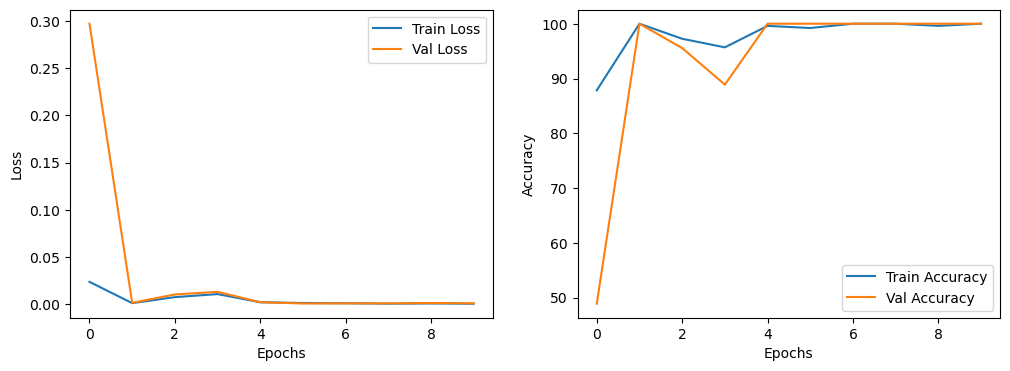

Model weights saved successfully.


In [19]:
import torch.nn.functional as F
# Define necessary params for model training 
#c2: " RETINA IMAGE AND DIABETIC RETINOPATHY: A DEEP LEARNING BASED APPROACH" 

# pre-trained DenseNet 121
model = models.densenet121(pretrained=True)

# binary classific
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 1) # replace last layer witg new fully connected layer for binary 

# Switch to GPU (colab?)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function: binary cross entropy loss with logits: binary cross entropy between target & iput logit 
# focal loss emphasizes hard-to-classify samples (c2)
def focal_loss(inputs, targets, alpha=0.25, gamma=2): #alpha for class imbalance, however, not case here
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none') 
    pt = torch.exp(-BCE_loss) # prob per example: predicted prob of true class : pt is high = model is confident 
    F_loss = alpha * (1-pt)**gamma * BCE_loss # loss contribution lower for confident samples
    return F_loss.mean()

# adam optimizer & lr schedule: cosine annealing learning rate schedule 
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# vars
num_epochs = 10
saveName = 'densenet121_Sept.pth' 

# Train the model
model = train_model(model, train_loader, val_loader, focal_loss, optimizer, scheduler, num_epochs, saveName)

## Evaluate CNN model (weights: densenet121_Sept.pth)

In [4]:
# evaluation of model on test set 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # plt.figure(figsize=(6, 6))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title('Confusion Matrix')
    # plt.show()

    return accuracy, precision, recall, f1

# Load the model if weights are saved already 
def load_model(saved_weights):
    model = models.densenet121(pretrained=True) # denseNet pre trained
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 1)
    model.load_state_dict(torch.load(saved_weights))
    model = model.to(device)
    return model

# evaluate model (not loading wights)
# Evaluate the model
#accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

In [5]:
"""
evaluated on full test set 
"""
# Path to the saved model weights
saved_weights = 'CNNModelWeights/densenet121_Sept.pth'

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = load_model(saved_weights)

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_loader) 

# 1 = DR
# 0 = No DR

#true
# 0
# 1
#   0 1  predicted

/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[41  9]
 [ 0 50]]
Accuracy: 0.9100
Precision: 0.8475
Recall: 1.0000
F1 Score: 0.9174


In [6]:
"""
evaluated on SMALL test set 
"""

small_model = load_model(saved_weights)

accuracy, precision, recall, f1 = evaluate_model(small_model, small_test_loader) 

/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/berbervandrunen/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[[4 2]
 [0 6]]
Accuracy: 0.8333
Precision: 0.7500
Recall: 1.0000
F1 Score: 0.8571


## Visual XAI

Individual visual XAI (Grad-CAM, saliency maps, integrated gradients shap lime ? )
* model = evaluated on test_loader
* small_model = evaluated on small_test_loader

Maybe best to use grad-CAM:

"Gradient-based techniques (Chaddad et al., 2023; Ennab & Mcheick, 2022), such as Grad-CAM, use gradients to create heatmaps, providing real-time visual explanations, while perturbation-based methods, like LIME, alter input data to observe changes in predictions, offering robust, model-agnostic explanations though often at higher computational cost."

In [16]:
!pip install pytorch-gradcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 5.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5246 sha256=6e33d34fa9455e36cd00da90075980b1a1fd2846a5c84496131f49c86c51a9da
  Stored in directory: /Users/berbervandrunen/Library/Caches/pip/wheels/20/d6/4e/1ac02c54faee563b4d06015456c6c5d85550dcec878740f37d
Successfully built pytorch-gradcam


### GRAD CAM (model specific XAI: model internal workings) (also gradient based)

In [9]:
import numpy as np
import cv2
import torch.nn.functional as F

# GradCAM explanations 

"""
Extracting intermediate feature maps:
compute gradients of the target class wrt conv layer 
"""
class FeatureExtractor:
    """ Class for extracting (intermediate?) activations and registering gradients from target intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []
        self.activations = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        for name, module in self.model.features._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                self.activations.append(x)
        return self.activations, x

"""
Generate grad-CAM for sinle image
>> feature extraction, prediction, backward pass for grad computation, generation of class activation map (CAM)
"""
def generate_heatmap(model, image, target_layer):
    extractor = FeatureExtractor(model, target_layer)
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Forward pass to get predictions and target feature maps
    target_activations, output = extractor(image)
    output = F.relu(output, inplace=True)
    output = F.adaptive_avg_pool2d(output, (1, 1)).view(output.size(0), -1)
    output = model.classifier(output)
    pred_class = torch.sigmoid(output).round().item()

    # Backward pass to get gradients wrt the predicted class
    model.zero_grad()
    class_loss = output[0]  # For binary classification
    class_loss.backward(retain_graph=True)

    #  gradients and target layer output
    gradients = extractor.gradients[0].cpu().data.numpy()
    target = target_activations[0].cpu().data.numpy()

    #  heatmap
    weights = np.mean(gradients, axis=(2, 3))[0, :]
    cam = np.zeros(target.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * target[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    #print(cam, pred_class)
    return cam, pred_class

# Visualize 
def visualize_heatmap(original_image, heatmap, image_name):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Since normalization is skipped, directly convert the tensor to a numpy array
    original_image = original_image.cpu().permute(1, 2, 0).numpy()
    original_image = np.clip(original_image, 0, 1)
    
    superimposed_img = heatmap + np.float32(original_image)
    superimposed_img = superimposed_img / np.max(superimposed_img)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image 
    ax[0].imshow(original_image)
    ax[0].set_title(image_name)
    ax[0].axis('off')
    
    # Grad-CAM heatmap
    ax[1].imshow(superimposed_img)
    ax[1].set_title('Grad-CAM Heatmap')
    ax[1].axis('off')
    
    plt.show()

"""
Evaluate + Grad-CAM heatmaps
But only for images where the true label is 1 (only BB for DR images)
"""
def evaluate_and_visualize_gradcam(model, test_loader, device, target_layer, num_images):
    count = 0  # To count how many images we have visualized
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).round().detach().cpu().numpy()  # Detach and convert to numpy
        
        for i in range(images.size(0)):  # Iterate over each image in the batch
            label = labels.cpu().numpy()[i]
            prediction = preds[i][0]

            # Only show when DR is present, i.e., label == 1
            if label == 1:  
                image_name = f"Actual: 1, Predicted: {prediction}"

                # Grad-CAM heatmap
                heatmap, pred_class = generate_heatmap(model, images[i], target_layer)

                # Visualize heatmap with the image label/name as title
                visualize_heatmap(images[i], heatmap, image_name)
                
                count += 1

            # Stop once we have visualized `num_images` images with `label == 1`
            if count >= num_images:
                break

        # Break the outer loop as well if enough images are visualized
        if count >= num_images:
            break



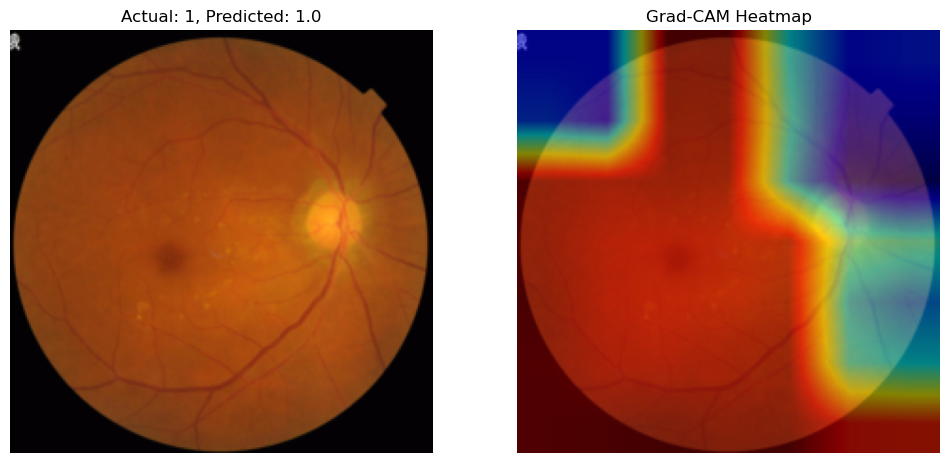

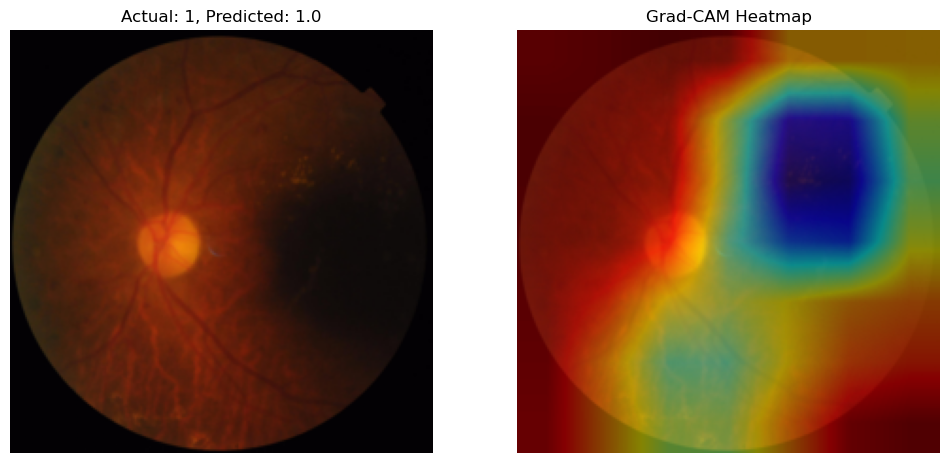

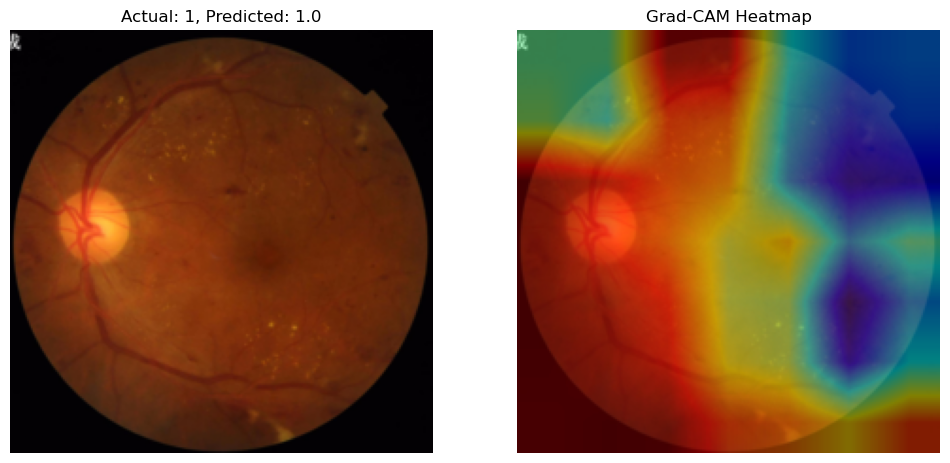

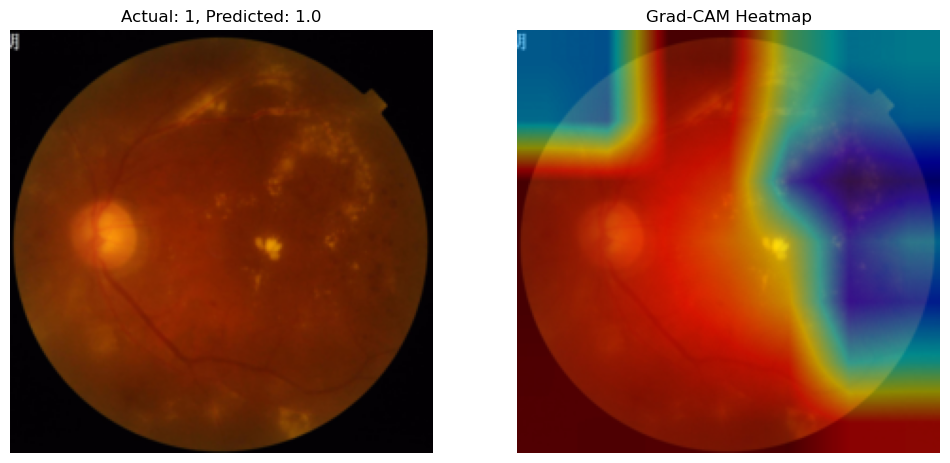

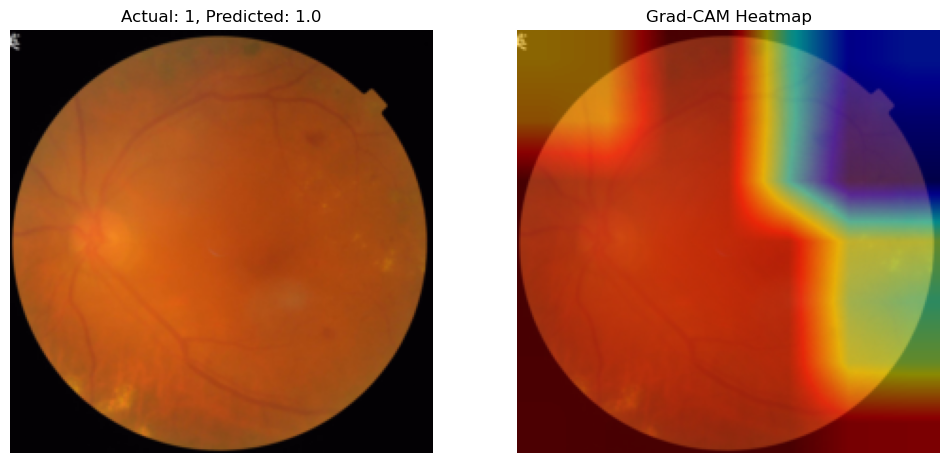

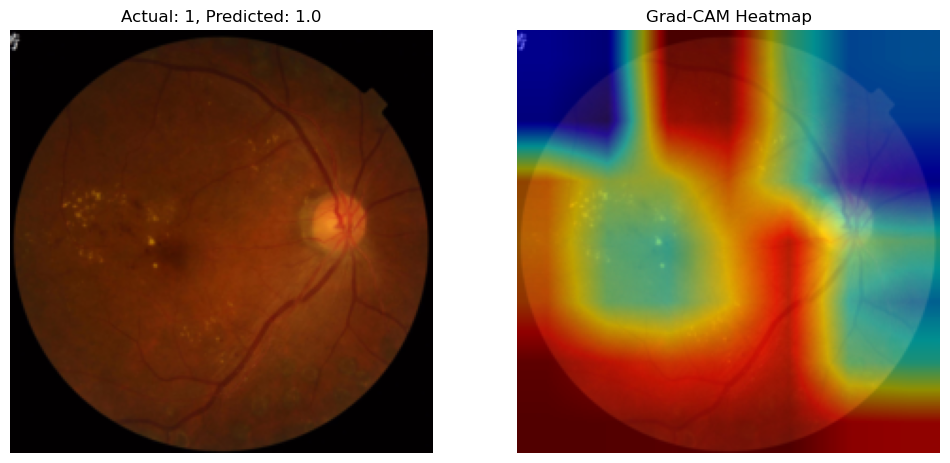

In [10]:
""" on SMALL TEST set small_model and small_test_loader) """

# ! only visualizes DR cases
evaluate_and_visualize_gradcam(small_model, small_test_loader, device, target_layer=['denseblock4'], num_images=6)

### LIME (local XAI: focus on individual preduictions (local vars))

  0%|          | 0/1000 [00:00<?, ?it/s]

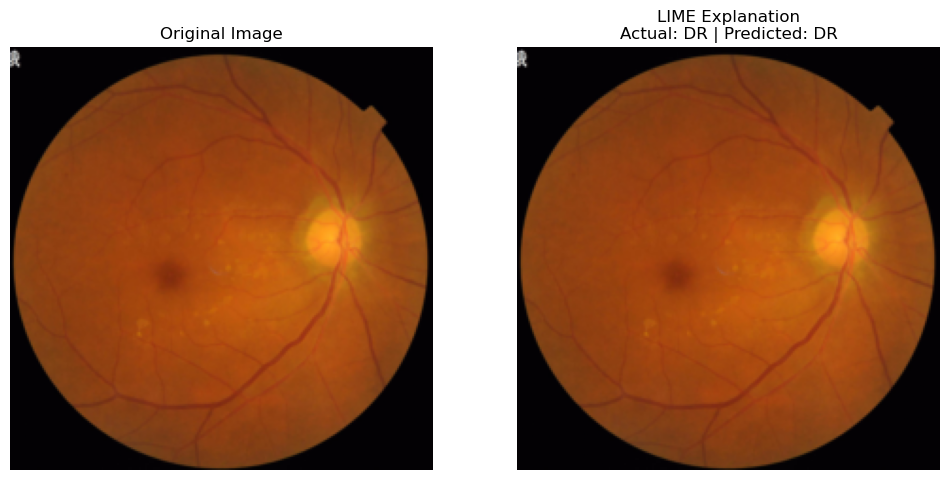

In [11]:
# get LIME maps over the test input images
from lime import lime_image

def get_LIME(model, test_loader, device, num_images=6):
    # Prediction function for LIME
    def predict_fn(images):
        model.eval()
        images = [transforms.ToTensor()(image).unsqueeze(0) for image in images]  # Convert each image to tensor
        images = torch.cat(images).to(device)  # Concatenate to batch and move to device (e.g., GPU)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().detach().numpy()  # Apply sigmoid to get probabilities
        return np.concatenate([1 - probs, probs], axis=1)  # Return the probability of both classes (no DR, DR)

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Visualize LIME explanation for the image
    def visualize_explanation(original_image, label, prediction, explanation, incorrect=False):
        # Get image and mask based on the LIME explanation
        temp, mask = explanation.get_image_and_mask(
            label=prediction,  # Predicted label
            positive_only=not incorrect,  # Show positive features only for correct prediction
            num_features=5,  # Number of superpixels/features to highlight
            hide_rest=False  # Do not hide the other parts of the image
        )

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # Original image
        original_image = original_image.cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy array
        original_image = np.clip(original_image, 0, 1)  # Ensure values are within a valid range
        ax[0].imshow(original_image)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        # LIME explanation plot
        ax[1].imshow(temp)
        ax[1].set_title(f'LIME Explanation\nActual: {"DR" if label == 1 else "No DR"} | Predicted: {"DR" if prediction == 1 else "No DR"}')
        ax[1].axis('off')

        plt.show()

    # Iterate through the test loader and process only the first `num_images` images
    count = 0
    for images, labels in test_loader:
        if count >= num_images:
            break

        images = images.to(device)  # Move images to the same device as the model
        labels = labels.to(device)
        outputs = model(images)  # Get model predictions
        probs = torch.sigmoid(outputs)  # Get probabilities
        preds = (probs > 0.5).float()  # Get binary predictions

        label = labels.cpu().numpy()[0]  # Get actual label
        prediction = preds.cpu().numpy()[0][0]  # Get predicted label

        # Get LIME explanation
        explanation = explainer.explain_instance(
            image=images[0].cpu().permute(1, 2, 0).numpy(),  # Convert tensor to numpy array
            classifier_fn=predict_fn,  # Function to use for predictions
            top_labels=2,  # Consider top 2 labels (binary classification)
            hide_color=0,  # Color to hide regions with (0 means black)
            num_samples=1000  # Number of perturbations to generate for LIME
        )

        # If the prediction is correct
        if label == prediction:
            visualize_explanation(images[0], label, prediction, explanation)
        # If the prediction is incorrect
        else:
            visualize_explanation(images[0], label, prediction, explanation, incorrect=True)

        count += 1


get_LIME(small_model, small_test_loader, device, num_images=6)



### INTEGRATED GRADIETS

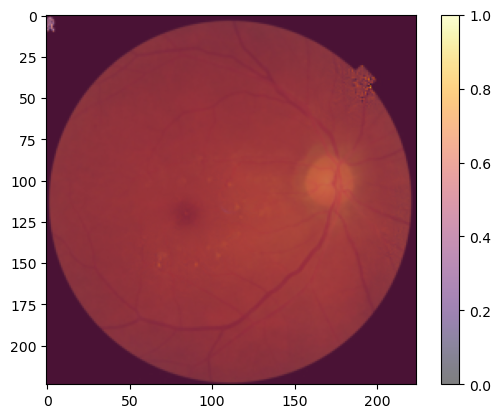

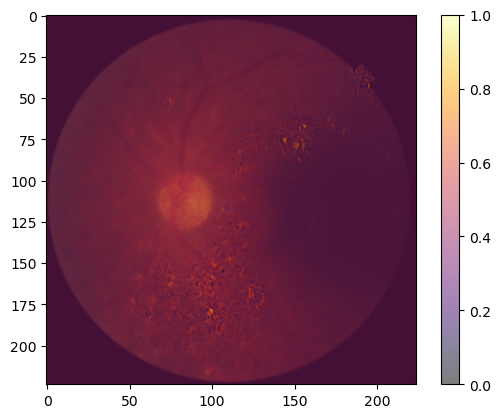

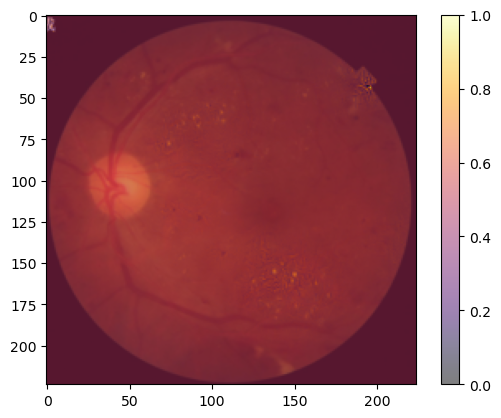

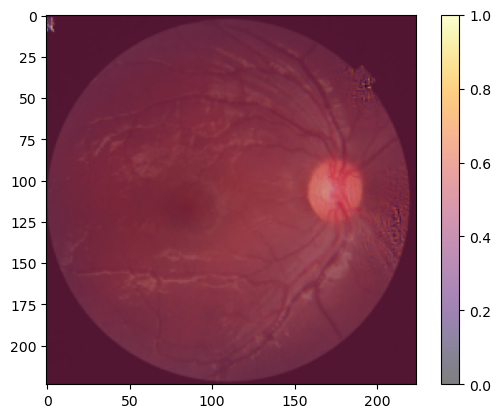

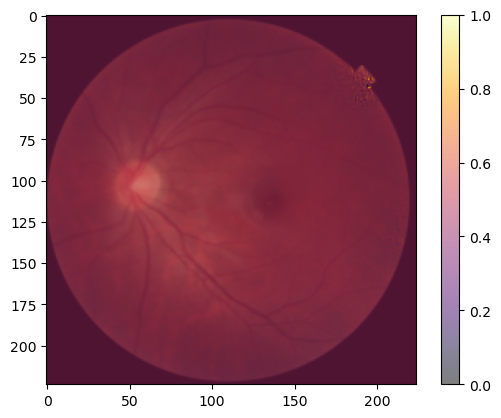

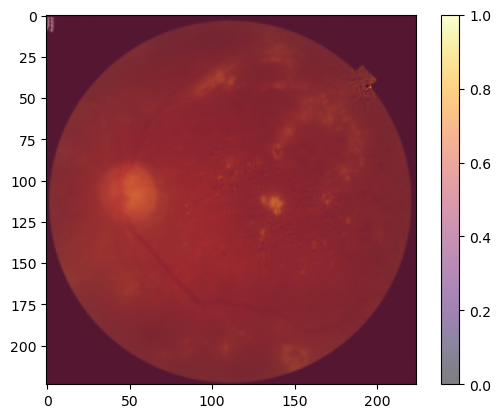

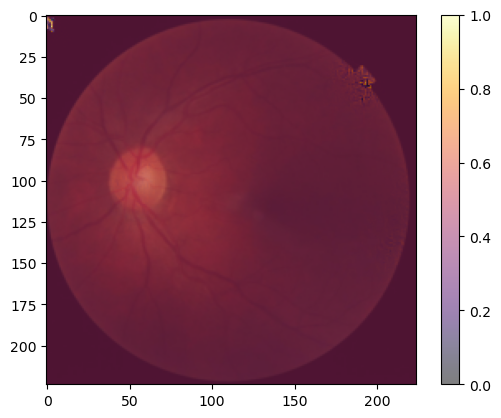

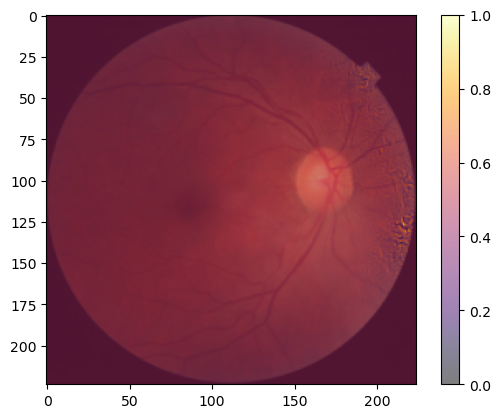

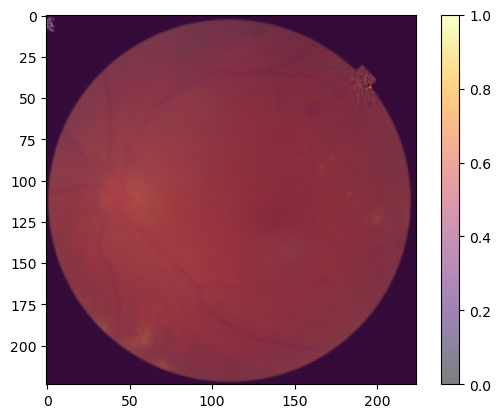

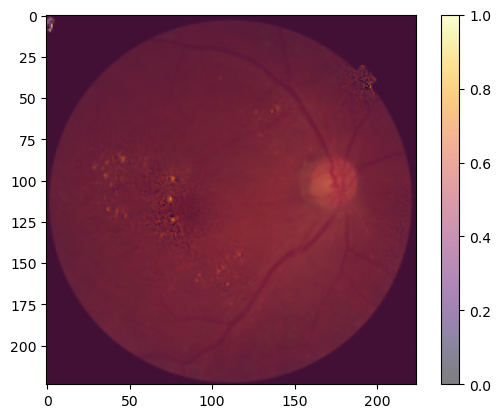

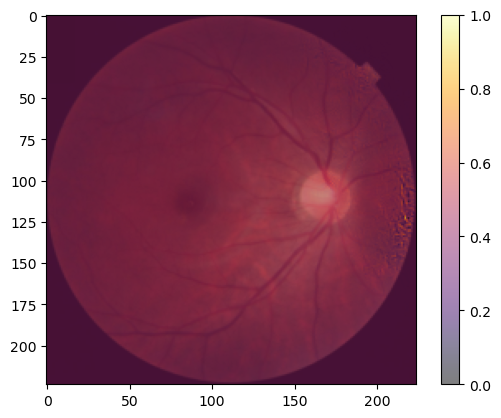

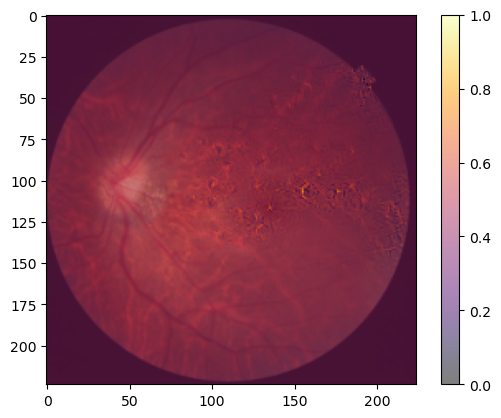

In [12]:
def integrated_gradients(model, image, steps=50):
    model.eval()
    
    baseline = torch.zeros_like(image).to(device)
    scaled_inputs = [baseline + (float(i) / steps) * (image - baseline) for i in range(steps+1)]
    scaled_inputs = torch.stack(scaled_inputs).to(device)
    
    # Forward pass and gradient computation
    grads = []
    for scaled_image in scaled_inputs:
        scaled_image.requires_grad_()
        output = model(scaled_image.unsqueeze(0).to(device))
        score = output.squeeze()
        model.zero_grad()
        score.backward()
        grads.append(scaled_image.grad.data.clone())

    avg_grads = torch.mean(torch.stack(grads), dim=0)
    
    # Integrated gradients
    integrated_grads = (image - baseline) * avg_grads
    integrated_grads = integrated_grads.sum(dim=0).cpu().numpy()

    # Normalize
    integrated_grads = (integrated_grads - integrated_grads.min()) / (integrated_grads.max() - integrated_grads.min())

    return integrated_grads

# Visualize integrated gradients
def visualize_integrated_gradients(igrads, original_image):
    plt.imshow(original_image.squeeze().permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.imshow(igrads, cmap='inferno', alpha=0.5)
    plt.colorbar()
    plt.show()

# Example usage:
for images, labels in small_test_loader:
    for i, (image, label) in enumerate(zip(images, labels)):
        igrads = integrated_gradients(small_model, image)
        visualize_integrated_gradients(igrads, image)


### OCCLUSION SENSITIVITY

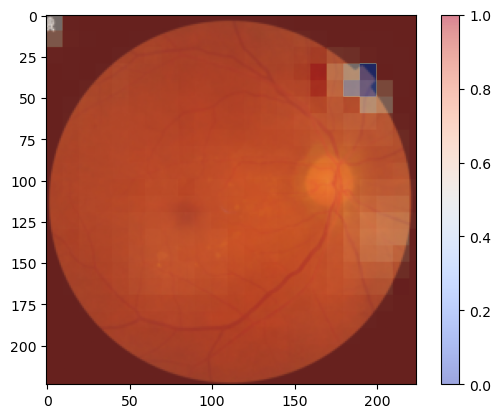

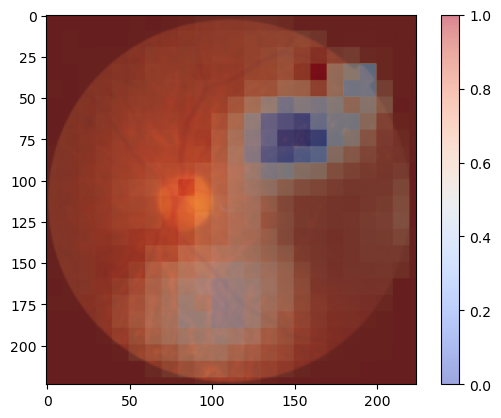

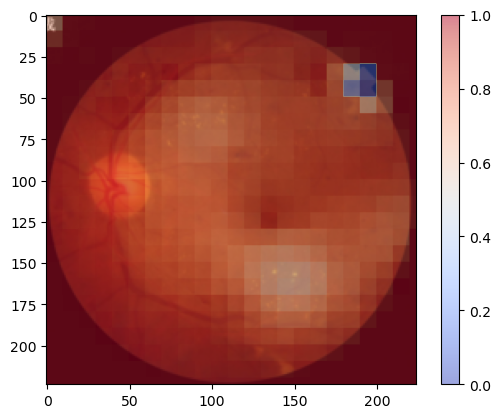

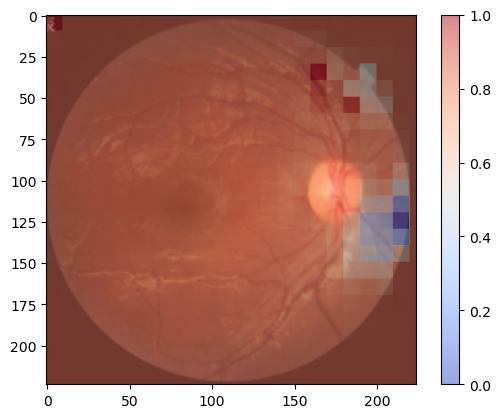

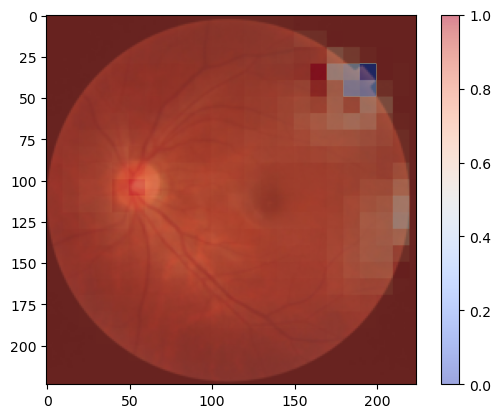

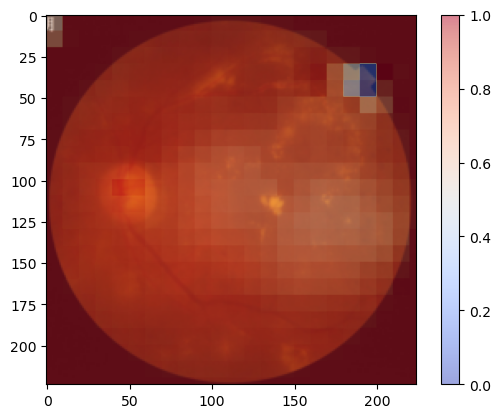

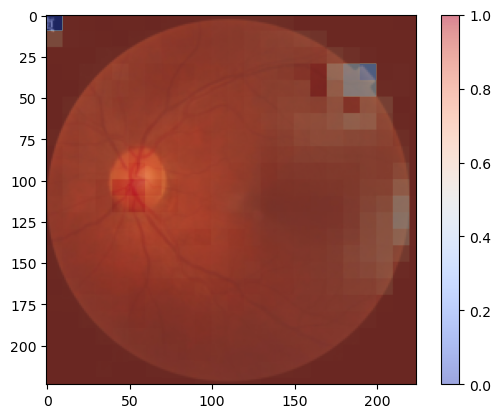

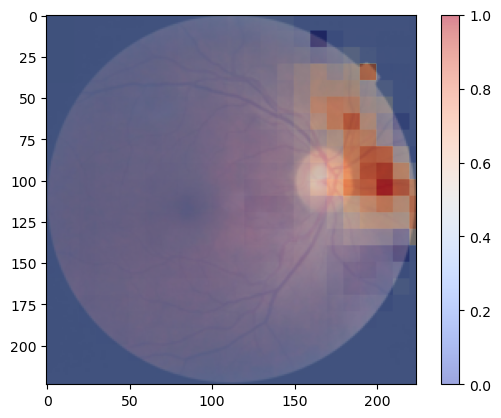

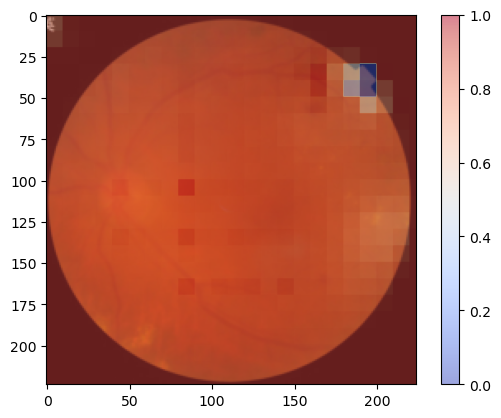

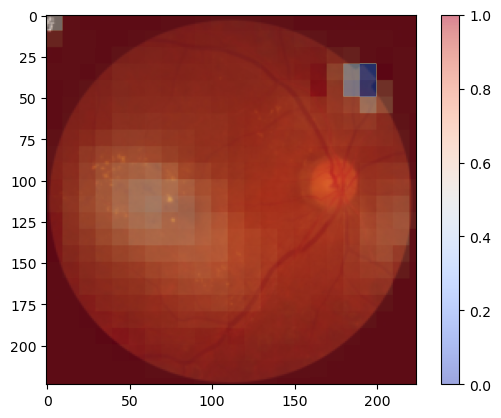

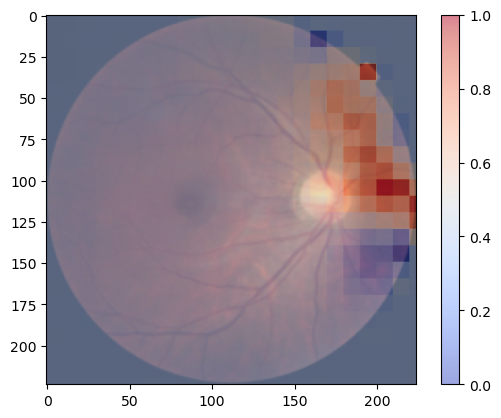

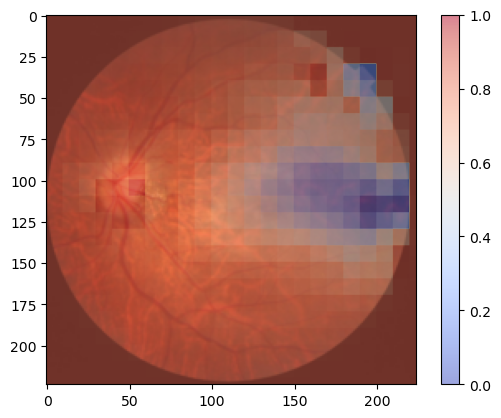

In [13]:
def occlusion_sensitivity(model, image, occlusion_size=10):
    model.eval()
    image = image.unsqueeze(0).to(device)
    heatmap = np.zeros(image.squeeze().shape[1:])
    
    for i in range(0, image.size(2), occlusion_size):
        for j in range(0, image.size(3), occlusion_size):
            occluded_image = image.clone()
            occluded_image[:, :, i:i+occlusion_size, j:j+occlusion_size] = 0  # Mask part of the image
            
            output = model(occluded_image)
            prediction = output.item()  # Extract the prediction for DR
            
            heatmap[i:i+occlusion_size, j:j+occlusion_size] = prediction

    # Normalize the heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    return heatmap

# Visualize occlusion sensitivity
def visualize_occlusion(heatmap, original_image):
    plt.imshow(original_image.squeeze().permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.imshow(heatmap, cmap='coolwarm', alpha=0.5)
    plt.colorbar()
    plt.show()

# Example usage:
for images, labels in small_test_loader:
    for i, (image, label) in enumerate(zip(images, labels)):
        heatmap = occlusion_sensitivity(small_model, image)
        visualize_occlusion(heatmap, image)


### SALIENCY

error you're encountering is due to the use of in-place operations (such as ReLU(inplace=True)) inside the DenseNet model. These operations are interfering with the backward pass and gradient computations required for saliency maps and SHAP. To resolve this, we need to modify the model to avoid using in-place operations during the forward pass

In [115]:
# for param in small_model.parameters():
    # param.requires_grad = True

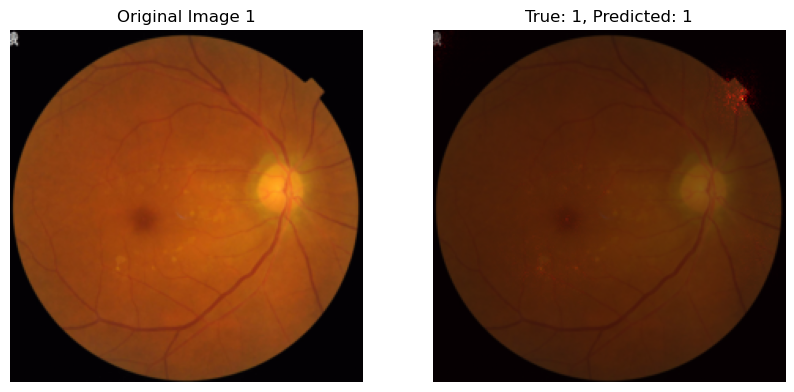

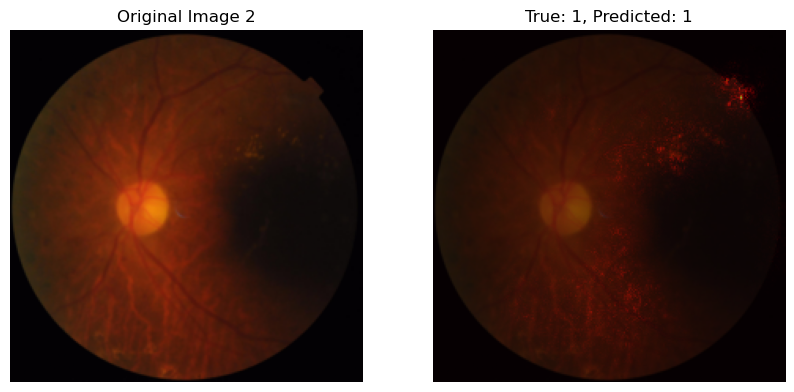

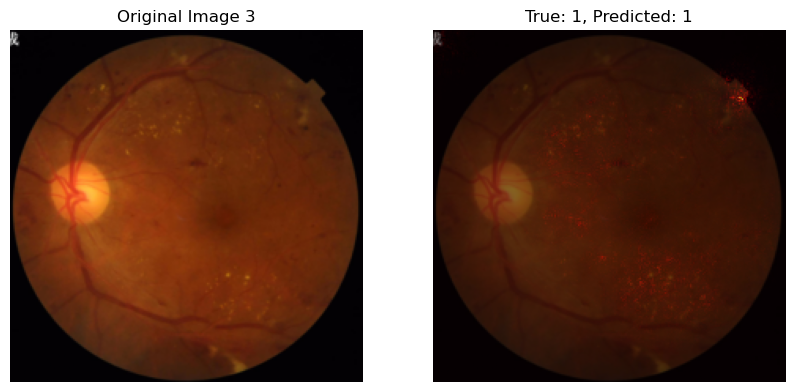

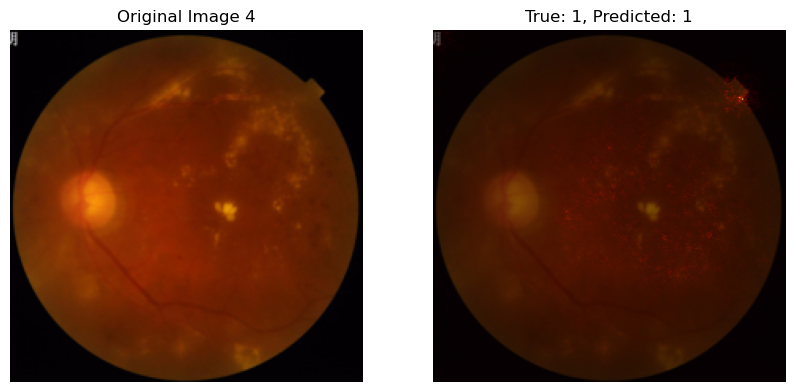

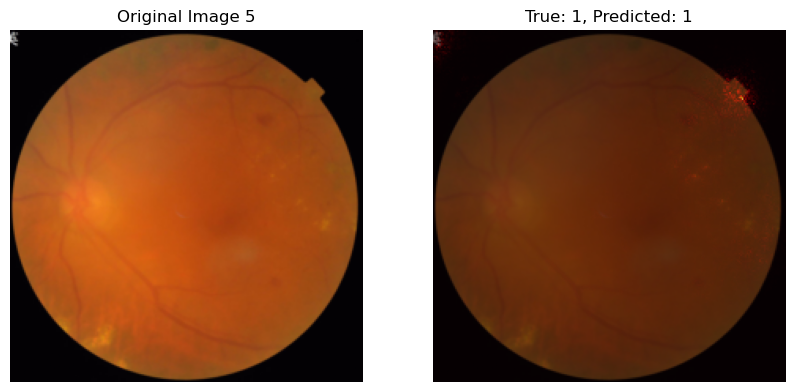

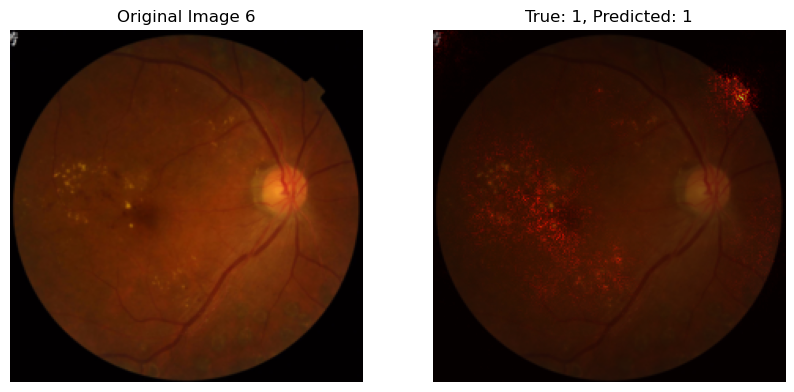

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to generate saliency map
def generate_saliency_map_Single(model, image):
    image.requires_grad_()  # Enable gradients on the image
    
    # Forward pass
    model.eval()
    output = model(image)
    
    # Get the scalar score (output) for binary classification
    score = output[0]  # For binary classification, there's only one output

    # Backprop to calculate gradients
    model.zero_grad()
    score.backward()
    
    # Get the gradient of the input image
    saliency = image.grad.data.abs().squeeze().cpu().numpy()

    # Normalize the saliency map
    saliency = np.max(saliency, axis=0)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-7)  # Avoid division by zero
    
    return saliency, output.sigmoid().item()  # Return both saliency and predicted score

def generate_saliency_map(model, image):
    image = image.unsqueeze(0).to(device)  # Add batch dimension (unsqueeze) and move to device
    image.requires_grad_()  # Enable gradients on the image
    
    # Forward pass
    model.eval()
    output = model(image)
    
    # Get the scalar score (output) for binary classification
    score = output[0]  # For binary classification, there's only one output

    # Backprop to calculate gradients
    model.zero_grad()
    score.backward()
    
    # Get the gradient of the input image
    saliency = image.grad.data.abs().squeeze().cpu().numpy()

    # Normalize the saliency map
    saliency = np.max(saliency, axis=0)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-7)  # Avoid division by zero
    
    return saliency, output.sigmoid().item()  # Return both saliency and predicted score


# Function to visualize original image next to saliency map
def visualize_saliency_map(image, saliency_map, true_label, pred_label, image_idx):
    # Detach image from the computation graph and convert it to a numpy array
    original_image = image.detach().squeeze().cpu().permute(1, 2, 0).numpy()
    original_image = np.clip(original_image, 0, 1)  # Ensure the pixel values are between 0 and 1
    
    # Plot the original image and saliency map side by side
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f'Original Image {image_idx}')
    
    # Saliency map
    plt.subplot(1, 2, 2)
    plt.imshow(original_image, cmap='gray')
    plt.imshow(saliency_map, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.title(f'True: {true_label}, Predicted: {round(pred_label)}')
    
    plt.show()


# Loop through the test loader, filter images with label 1 (DR), and generate saliency maps
def visualize_saliency_for_DR_images(model, test_loader):
    image_idx = 0  # To keep track of image number
    
    for batch_images, batch_labels in test_loader:
        for i, (image, label) in enumerate(zip(batch_images, batch_labels)):
            if label.item() == 1:  # Only consider images with DR (label 1)
                image_idx += 1  # Increment image counter
                
                # Move image to the correct device and unsqueeze for batch size of 1
                image = image.unsqueeze(0).to(device)
                
                # Generate saliency map and get the predicted label
                saliency_map, pred_label = generate_saliency_map_Single(model, image)
                
                # Visualize the original image next to the saliency map with true and predicted labels
                visualize_saliency_map(image, saliency_map, true_label=label.item(), pred_label=pred_label, image_idx=image_idx)

# Call the function to visualize saliency maps for DR images
visualize_saliency_for_DR_images(small_model, small_test_loader)


### COMBINED ALL OF THE ABOVE (5)

  0%|          | 0/1000 [00:00<?, ?it/s]

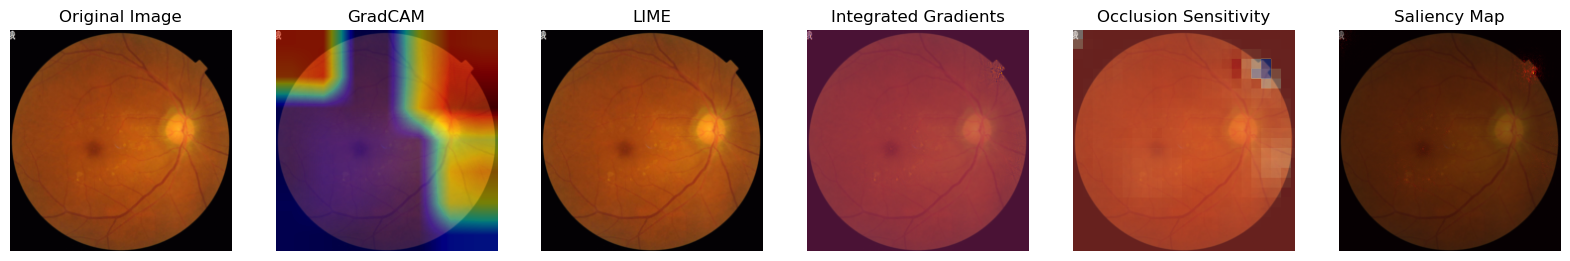

  0%|          | 0/1000 [00:00<?, ?it/s]

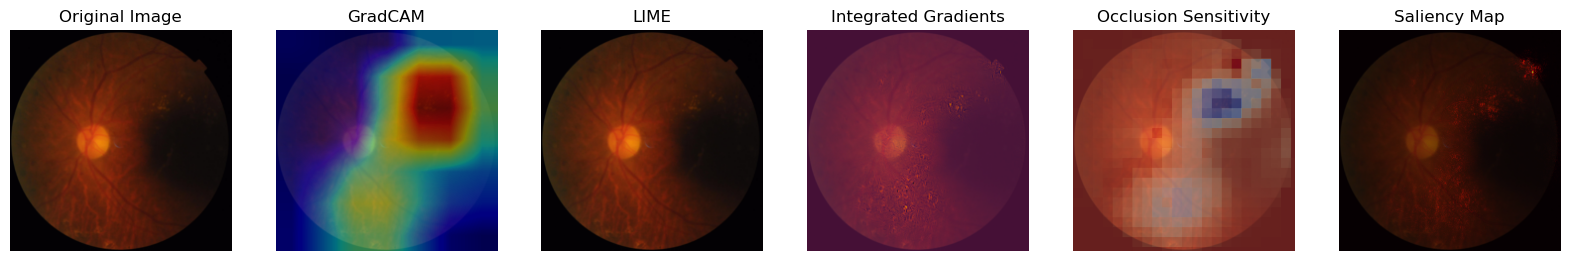

  0%|          | 0/1000 [00:00<?, ?it/s]

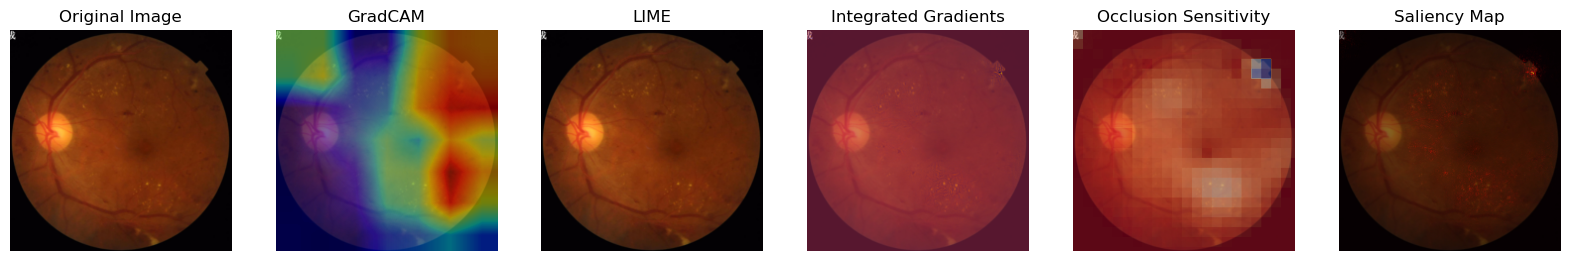

  0%|          | 0/1000 [00:00<?, ?it/s]

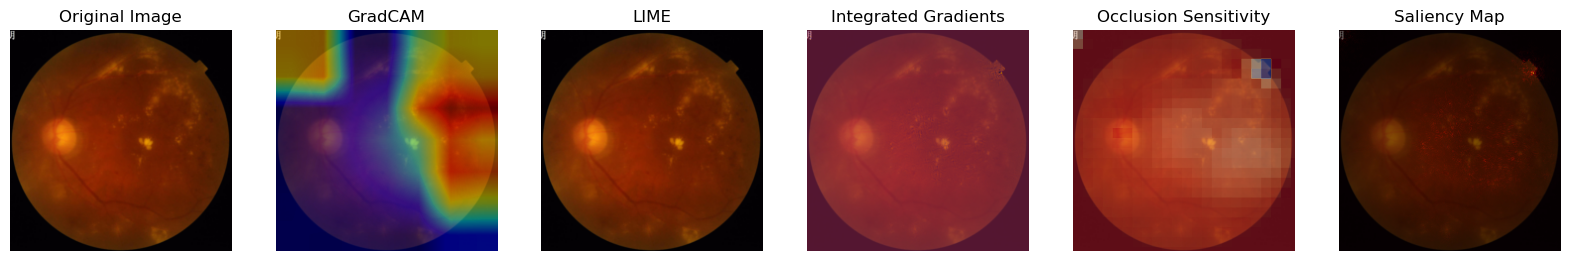

  0%|          | 0/1000 [00:00<?, ?it/s]

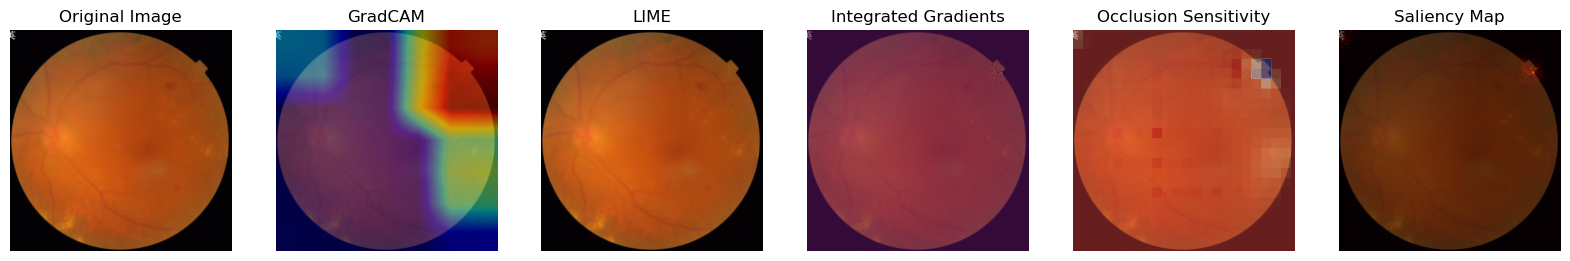

  0%|          | 0/1000 [00:00<?, ?it/s]

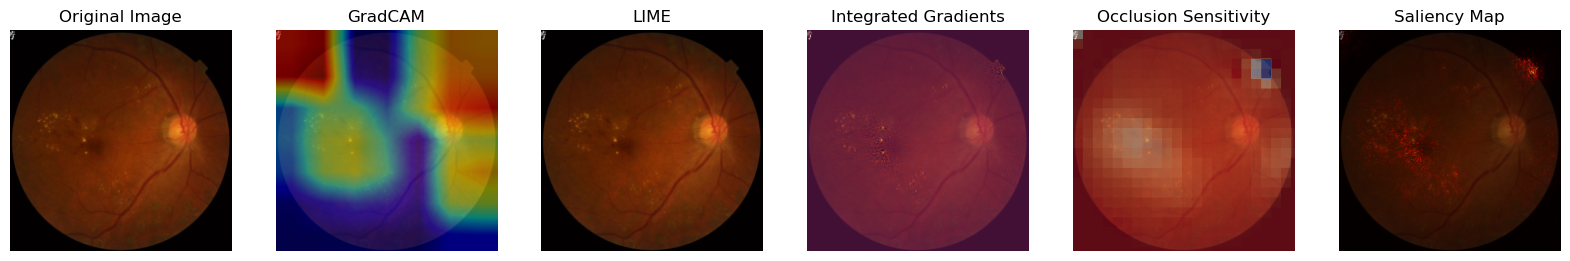

In [16]:
import matplotlib.pyplot as plt

def compare_visual_xai_methods(model, image, label, device, save_path=None):
    # image is already 4D (batch size of 1), so no need to unsqueeze it again
    image = image.to(device)  # Ensure it's 4D (batch size 1)

    # Generate GradCAM
    gradcam_heatmap, _ = generate_heatmap(model, image, target_layer=['denseblock4'])

    # Generate LIME explanation
    def predict_fn(images):
        model.eval()
        images = [transforms.ToTensor()(image).unsqueeze(0) for image in images]  # Convert each image to tensor
        images = torch.cat(images).to(device)  # Concatenate to batch and move to device
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        return np.concatenate([1 - probs, probs], axis=1)  # Return the probability of both classes (no DR, DR)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=image.squeeze().cpu().permute(1, 2, 0).numpy(),  # Convert tensor to numpy array
        classifier_fn=predict_fn,
        top_labels=2, num_samples=1000
    )
    temp, lime_mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=5, hide_rest=False)

    # Generate Integrated Gradients
    igrads = integrated_gradients(model, image.squeeze())

    # Generate Occlusion Sensitivity
    occlusion_heatmap = occlusion_sensitivity(model, image.squeeze())

    # Generate Saliency Map
    saliency_map, _ = generate_saliency_map(model, image)

    # Visualize all in one grid
    fig, axs = plt.subplots(1, 6, figsize=(20, 5))

    # Original image
    original_image = image.squeeze().cpu().permute(1, 2, 0).numpy()
    original_image = np.clip(original_image, 0, 1)  # Ensure values are within a valid range
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # GradCAM
    axs[1].imshow(original_image, cmap='gray')
    axs[1].imshow(gradcam_heatmap, cmap='jet', alpha=0.5)
    axs[1].set_title('GradCAM')
    axs[1].axis('off')

    # LIME
    axs[2].imshow(temp)
    axs[2].set_title('LIME')
    axs[2].axis('off')

    # Integrated Gradients
    axs[3].imshow(original_image, cmap='gray')
    axs[3].imshow(igrads, cmap='inferno', alpha=0.5)
    axs[3].set_title('Integrated Gradients')
    axs[3].axis('off')

    # Occlusion Sensitivity
    axs[4].imshow(original_image, cmap='gray')
    axs[4].imshow(occlusion_heatmap, cmap='coolwarm', alpha=0.5)
    axs[4].set_title('Occlusion Sensitivity')
    axs[4].axis('off')

    # Saliency Map
    axs[5].imshow(original_image, cmap='gray')
    axs[5].imshow(saliency_map, cmap='hot', alpha=0.5)
    axs[5].set_title('Saliency Map')
    axs[5].axis('off')

    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)  # Save the figure with high resolution

    plt.show()

# Example usage for one image
for images, labels in small_test_loader:
    for i, (image, label) in enumerate(zip(images, labels)):
        if label.item() == 1:  # Only show for DR-positive cases
            compare_visual_xai_methods(small_model, image, label, device, save_path='visual_xai_comparison.png')
            #break  # Show only one image for now


### SHAP

### try3

GradCam

In [59]:
# Visualize Grad-CAM for DR predictions
def visualize_heatmap_with_bboxes(original_image, heatmap, image_name, threshold=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Since normalization is skipped, directly convert the tensor to a numpy array
    original_image = original_image.cpu().permute(1, 2, 0).numpy()
    original_image = np.clip(original_image, 0, 1)
    
    superimposed_img = heatmap + np.float32(original_image)
    superimposed_img = superimposed_img / np.max(superimposed_img)

    # Generate bounding boxes based on the heatmap
    binary_map = np.uint8(heatmap[:, :, 1] > threshold)  # Use channel 1 of heatmap
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    original_image_uint8 = (original_image * 255).astype(np.uint8)

    # Draw bounding boxes on the original image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(original_image_uint8, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Plot the image with bounding boxes
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image with bounding boxes
    ax[0].imshow(original_image_uint8)
    ax[0].set_title(image_name + " with Bounding Boxes")
    ax[0].axis('off')
    
    # Grad-CAM heatmap
    ax[1].imshow(superimposed_img)
    ax[1].set_title('Grad-CAM Heatmap')
    ax[1].axis('off')
    
    plt.show()
    
def visualize_gradcam_for_DR(model, test_loader, device, target_layer=['denseblock4'], threshold=0.5, num_images=6):
    count = 0
    for images, labels in test_loader:  # Unpack only images and labels
        if count >= num_images:
            break
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).round().detach().cpu().numpy()  # Detach and convert to numpy

        label = labels.cpu().numpy()[0]
        prediction = preds[0][0]

        # Process only if DR is predicted (1)
        if prediction == 1:  
            # If you want to keep track of the image paths, you can access them from the dataset using the index
            image_name = f"Image {count}"  # You can customize how you handle image naming

            # Generate Grad-CAM heatmap
            heatmap, pred_class = generate_heatmap(model, images[0], target_layer)

            # Visualize heatmap with the image filename as title
            visualize_heatmap_with_bboxes(images[0], heatmap, image_name, threshold)
            #visualize_heatmap(images[0], heatmap, image_name)
        count += 1




In [60]:
# Assuming your test_loader is set up with the appropriate dataset
visualize_gradcam_for_DR(model, test_loader, device, target_layer=['denseblock4'], threshold=0.5, num_images=5)


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


Saliency Map

In [56]:
def generate_saliency_map(model, image, target_class):
    image.requires_grad_()
    
    # Forward pass
    model.eval()
    output = model(image)
    
    # Get score for the target class
    score = output[:, target_class].sum()

    # Backprop to calculate gradients
    model.zero_grad()
    score.backward()
    
    # Get the gradient of the input image
    saliency = image.grad.data.abs().squeeze().cpu().numpy()

    # Normalize the saliency map
    saliency = np.max(saliency, axis=0)
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    
    return saliency

def visualize_saliency_map(model, image, target_class):
    saliency_map = generate_saliency_map(model, image, target_class)
    
    # Plot the saliency map
    plt.imshow(saliency_map, cmap='hot')
    plt.axis('off')
    plt.title('Saliency Map')
    plt.show()


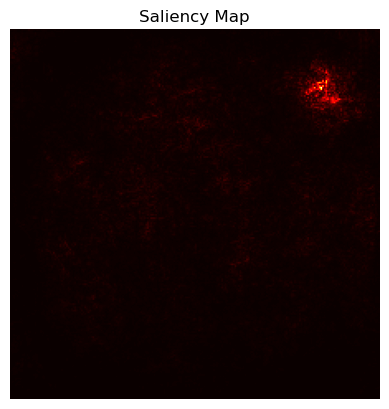

In [58]:
# For a specific image:
image, label = next(iter(test_loader))  # Get a batch from the test loader
image = image[0].unsqueeze(0).to(device)  # Take the first image from the batch

# Saliency map for the predicted class
pred_class = 0  # You can modify this based on your output
visualize_saliency_map(model, image, pred_class)


Integrated Gradients

In [46]:
!pip install captum

  Obtaining dependency information for captum from https://files.pythonhosted.org/packages/e1/76/b21bfd2c35cab2e9a4b68b1977f7488c246c8cffa31e3361ee7610e8b5af/captum-0.7.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:0000:0100:01


In [47]:
from captum.attr import IntegratedGradients

def generate_integrated_gradients(model, image, target_class, baseline=None):
    # Use Captum to generate integrated gradients
    integrated_gradients = IntegratedGradients(model)
    
    if baseline is None:
        baseline = torch.zeros_like(image).to(device)  # A black image as baseline

    attributions = integrated_gradients.attribute(image, baseline, target=target_class)
    
    return attributions.squeeze().cpu().detach().numpy()

def visualize_integrated_gradients(attributions):
    # Normalize and visualize
    attribution_image = np.mean(attributions, axis=0)  # Take the mean over channels
    attribution_image = np.maximum(attribution_image, 0)  # ReLU
    attribution_image = (attribution_image - attribution_image.min()) / (attribution_image.max() - attribution_image.min())

    plt.imshow(attribution_image, cmap='hot')
    plt.axis('off')
    plt.title('Integrated Gradients')
    plt.show()


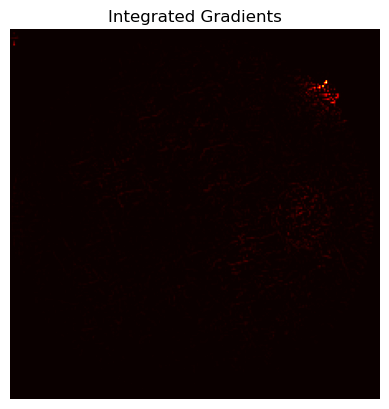

In [61]:

# Integrated gradients for the predicted class
attributions = generate_integrated_gradients(model, image, pred_class)
visualize_integrated_gradients(attributions)


In [ ]:
# Assuming your test_loader is set up with the appropriate dataset
visualize_gradcam_for_DR(model, test_loader, device, target_layer=['denseblock4'], num_images=5)

# For a specific image:
image, label = next(iter(test_loader))  # Get a batch from the test loader
image = image[0].unsqueeze(0).to(device)  # Take the first image from the batch

# Saliency map for the predicted class
pred_class = 1  # You can modify this based on your output
visualize_saliency_map(model, image, pred_class)

# Integrated gradients for the predicted class
attributions = generate_integrated_gradients(model, image, pred_class)
visualize_integrated_gradients(attributions)
